### **Importing Libraries**

In [1]:
import torch
import math
import copy
import torch.nn as nn
import torch.nn.functional as F
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from gensim.models import Word2Vec
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import string
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


cuda


### **Importing and Cleaning Dataset**

In [3]:
with open('./sample_data/Auguste_Maquet.txt', 'r', encoding='utf-8') as file:
    corpus = file.read()

print("Dataset Loaded")

corpus = corpus.lower()
clean_text = sent_tokenize(corpus)
translator = str.maketrans('', '', string.punctuation)
clean_text = [sentence.translate(translator) for sentence in clean_text]
# print(len(clean_text))

Dataset Loaded


### **Tokenization and Emmbedding**

In [5]:
tokenized_corpus = [word_tokenize(sentence) for sentence in clean_text]
word_to_ind = {}
longest_seq = 1
for i in range(len(tokenized_corpus)):
    token_arr = tokenized_corpus[i]
    longest_seq = max(longest_seq, len(token_arr))

    #Vocabulary
    for tokken in token_arr:
        if tokken not in word_to_ind:
            word_to_ind[tokken] = len(word_to_ind)

    token_arr = ['<sos>'] * 5 + token_arr + ['<eos>'] * 5
    tokenized_corpus[i] = token_arr

# print(tokenized_corpus[2])
word_to_ind["<sos>"] = len(word_to_ind)
word_to_ind["<eos>"] = len(word_to_ind)
# print(len(word_to_ind))

word2vec_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)
print("Prepare Word Embeddings")

Prepare Word Embeddings


### **Test-Train Split**

In [6]:
print("Splitting Data")
train_val_data, test_data = train_test_split(tokenized_corpus, test_size=0.2)

train_data, validation_data = train_test_split(train_val_data, test_size=0.125)

# Print the sizes of each set
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(validation_data)}")
print(f"Test data size: {len(test_data)}")


Splitting Data
Training data size: 24571
Validation data size: 3511
Test data size: 7021


## **Encoder**

### **Positional Encoding**

In [7]:
class PosEncoding(nn.Module):
    def __init__(self, model_dim, max_len):
        super(PosEncoding, self).__init__()
        pos_code = torch.zeros(max_len, model_dim).to(device)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1).to(device)
        scale = torch.exp(torch.arange(0, model_dim, 2, dtype=torch.float) *
                          -(math.log(10000.0) / model_dim)).to(device)

        pos_code[:, 0::2] = torch.sin(pos * scale)
        pos_code[:, 1::2] = torch.cos(pos * scale)

        # Registering the positional encoding matrix as a buffer to avoid updating during training
        self.register_buffer('pos_code', pos_code.unsqueeze(0))

    def forward(self, inp):
        seq_len = inp.size(1)
        inp = inp.to(device) + self.pos_code[:, :seq_len]

        return inp

### **Multi Head Attention**

In [8]:
# class MultiHeadAttention(nn.Module):
#     def __init__(self, model_dim, num_heads):
#         super(MultiHeadAttention, self).__init__()
#         self.model_dim = model_dim
#         self.num_heads = num_heads
#         self.dim_key = self.model_dim // self.num_heads

#         # Linear layers for query, key, and value
#         self.query = nn.Linear(model_dim, model_dim).to(device)
#         self.key = nn.Linear(model_dim, model_dim).to(device)
#         self.value = nn.Linear(model_dim, model_dim).to(device)
#         self.out = nn.Linear(model_dim, model_dim).to(device)

#     def attention_val(self, Q, K, V, mask=None):
#         score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.dim_key)

#         if mask is not None:
#             score = score.masked_fill(mask == 0, -1e9)

#         attn_weight = torch.softmax(score, dim=-1)

#         new_val = torch.matmul(attn_weight, V)
#         return new_val

#     def split_layers(self, x):
#         batch_size, seq_len, model_dim = x.size()
#         return x.view(batch_size, seq_len, self.num_heads, self.dim_key).transpose(1, 2)

#     def combine_layers(self, x):
#         batch_size, _, seq_len, dim_key = x.size()
#         return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.model_dim)

#     def forward(self, Q, K, V, mask=None):
#         # Split into multiple heads
#         Q = self.split_layers(self.query(Q).to(device))
#         K = self.split_layers(self.key(K).to(device))
#         V = self.split_layers(self.value(V).to(device))

#         layer_out = self.attention_val(Q, K, V, mask)
#         final_output = self.out(self.combine_layers(layer_out)).to(device)

#         return final_output


### **FeedForward**

In [9]:
class FeedForward(nn.Module):
    def __init__(self, model_dim, hid_dim):
        super(FeedForward, self).__init__()
        self.l1 = nn.Linear(model_dim, hid_dim).to(device)
        self.ac1 = nn.ReLU().to(device)
        self.l2 = nn.Linear(hid_dim, model_dim).to(device)

    def forward(self, inp):
        inp = self.l1(inp).to(device)
        inp = self.ac1(inp).to(device)
        inp = self.l2(inp).to(device)
        return inp

## **Decoder**

### **Combining Decoder**

In [10]:
class Decoder(nn.Module):
    def __init__(self, model_dim, num_heads, hid_dim, dropout):
        super(Decoder, self).__init__()
        self.self_attn = nn.MultiheadAttention(model_dim, num_heads, dropout).to(device)
        self.norm1 = nn.LayerNorm(model_dim).to(device)
        self.ffn1 = FeedForward(model_dim, hid_dim).to(device)
        self.norm2 = nn.LayerNorm(model_dim).to(device)
        self.dropout = nn.Dropout(dropout).to(device)

    def forward(self, inp, target_mask):

        att_score = self.self_attn(inp, inp, inp, target_mask)
        if isinstance(att_score, tuple):
            att_score = att_score[0]
        inp = self.norm1(inp + self.dropout(att_score)).to(device)
        ffn_out = self.ffn1(inp).to(device)
        inp = self.norm2(inp + self.dropout(ffn_out).to(device)).to(device)

        return inp

## **Transformer**

In [11]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, model_dim, num_layer, num_heads, hid_dim, max_len, dropout=0.1, pretrained_embeddings=None):
        super(Transformer, self).__init__()
        self.model_dim = model_dim
        if pretrained_embeddings is not None:
            self.embed = nn.Embedding.from_pretrained(torch.tensor(pretrained_embeddings, dtype=torch.float), freeze=True)
        else:
            self.embed = nn.Embedding(vocab_size, model_dim)

        self.pos_enc = PosEncoding(model_dim, max_len)
        self.decoders = nn.ModuleList([Decoder(model_dim, num_heads, hid_dim, dropout) for _ in range(num_layer)])
        self.final_layer = nn.Linear(model_dim, vocab_size)
        self.max_len = max_len

    def forward(self, src):
        src = src.to(device)
        src_mask = self.generate_square_subsequent_mask(src.size(0),src.size(1)).to(device)
        src_emb = self.pos_enc(self.embed(src))

        for decoder in self.decoders:
            src_emb = decoder(src_emb, src_mask)

        return self.final_layer(src_emb)

    def generate_square_subsequent_mask(self, sz, sz_1):
        mask = (torch.triu(torch.ones(sz, sz_1)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


### **Creating Datasets**

In [12]:
class LM_Dataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return (self.data.size(0) - 1) // self.seq_len

    def __getitem__(self, idx):
        start = idx * self.seq_len
        end = start + self.seq_len
        src = self.data[start:end]
        target = self.data[start+1:end+1]
        return src, target

### **Creating Input**

In [13]:
def prepare_data(sentences, word_to_index, max_len=None):
    def words_to_indices(words, word_to_index):
        return [word_to_index.get(word, 0) for word in words]

    all_indices = []

    for sentence in sentences:
        word_indices = words_to_indices(sentence, word_to_index)

        if max_len is not None:
            word_indices = word_indices[:max_len]

        all_indices.extend(word_indices)

    data = torch.LongTensor(all_indices)
    return data

train_gram_inp = prepare_data(train_data, word_to_ind, max_len=40)
val_gram_inp= prepare_data(validation_data, word_to_ind, max_len=40)
test_gram_inp = prepare_data(test_data, word_to_ind, max_len=40)

# Example output
# print(train_cen_inp[0])
print("Created input for loading")



Created input for loading


### **Train Model**

In [14]:
print("Training Begins")

dataset_train = LM_Dataset(train_gram_inp, 40)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

dataset_val = LM_Dataset(val_gram_inp, 40)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=16)

pretrained_embeddings = word2vec_model.wv.vectors

model = Transformer(vocab_size=len(word_to_ind), model_dim=100, num_heads=4, num_layer=6, hid_dim=300, max_len=40, dropout=0.1, pretrained_embeddings=pretrained_embeddings)
model.to(device)

num_epochs = 5
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
perp_vis_t = []
perp_vis_val = []

with open('2022101096_LM3_Train_Perplexity.txt', 'w') as train_file, open('2022101096_LM3_Validation_Perplexity.txt', 'w') as val_file:

    train_file.write(f'Epoch\tBatch\tPerplexity\n')
    val_file.write(f'Epoch\tBatch\tPerplexity\n')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_index, batch in enumerate(dataloader_train):
            context_words, target_words = batch
            context_words = context_words.to(device)
            target_words = target_words.to(device)

            optimizer.zero_grad()

            outputs = model(context_words)
            # print(f"Outputs shape: {outputs.shape}")
            # print(f"Outputs sample: {outputs[0, :5]}")

            outputs = outputs.view(-1, outputs.size(-1))
            target_words = target_words.view(-1)

            loss = criterion(outputs, target_words)
            # print(f"Loss: {loss.item()}")

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batch_perplexity_t = math.exp(loss.item())

            train_file.write(f'{epoch+1}\t{batch_index+1}\t{batch_perplexity_t:.4f}\n')

        avg_train_loss = total_loss / len(dataloader_train)
        train_perplexity = math.exp(avg_train_loss)


        # Validation loop
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in dataloader_val:
                context_words, target_words = batch
                context_words = context_words.to(device)
                target_words = target_words.to(device)

                outputs = model(context_words)
                outputs = outputs.view(-1, outputs.size(-1))
                target_words = target_words.view(-1)
                loss = criterion(outputs, target_words)
                total_val_loss += loss.item()
                batch_perplexity = math.exp(loss.item())

                val_file.write(f'{epoch+1}\t{batch_index+1}\t{batch_perplexity:.4f}\n')

                _, predicted = torch.max(outputs, 1)
                total += target_words.size(0)
                correct += (predicted == target_words).sum().item()


        avg_val_loss = total_val_loss / len(dataloader_val)
        val_perplexity = math.exp(avg_val_loss)
        accuracy = 100 * correct / total
        perp_vis_t.append(train_perplexity)
        perp_vis_val.append(val_perplexity)

        train_file.write(f'End of Epoch {epoch+1} - Average Train Perplexity: {train_perplexity:.4f}\n')
        val_file.write(f'End of Epoch {epoch+1} - Average Val Perplexity: {val_perplexity:.4f}\n')

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy:.2f}%')

print("Training and Validation Complete.")

Training Begins
Epoch [1/5], Train Loss: 4.7148, Val Loss: 4.3811, Val Accuracy: 29.47%
Epoch [2/5], Train Loss: 4.2491, Val Loss: 4.2790, Val Accuracy: 30.67%
Epoch [3/5], Train Loss: 4.1353, Val Loss: 4.2410, Val Accuracy: 31.06%
Epoch [4/5], Train Loss: 4.0655, Val Loss: 4.2373, Val Accuracy: 31.26%
Epoch [5/5], Train Loss: 4.0180, Val Loss: 4.2339, Val Accuracy: 31.37%
Training and Validation Complete.


### **Evaluate Model**

In [15]:
print("Testing Begins")

dataset_test = LM_Dataset(test_gram_inp, 40)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=16)

model.eval()
correct = 0
total = 0
total_loss = 0
total_tokens = 0
criterion = nn.CrossEntropyLoss()

with open('2022101096_LM3_Test_Perplexity.txt', 'w') as f:
    f.write(f'Batch\tPerplexity\n')

    with torch.no_grad():
        for batch_index, batch in enumerate(dataloader_test):
            context_words, target_words = batch
            context_words = context_words.to(device)
            target_words = target_words.to(device)

            outputs = model(context_words)
            outputs = outputs.view(-1, outputs.size(-1))
            target_words = target_words.view(-1)

            loss = criterion(outputs, target_words)
            total_loss += loss.item()
            perplexity = math.exp(loss.item())

            f.write(f'{batch_index+1}\t{perplexity:.4f}\n')

            _, predicted = torch.max(outputs, 1)
            total += target_words.size(0)
            correct += (predicted == target_words).sum().item()

        average_perplexity = math.exp(total_loss / len(dataloader_test))
        f.write(f'Average perplexity:\t{average_perplexity:.4f}\n')

accuracy = 100 * correct / total
average_loss = total_loss / len(dataloader_test)
perplexity = math.exp(average_loss)

print(f'Test Accuracy: {accuracy:.2f}%')
print(f'Average Test Loss: {average_loss:.4f}')
print(f'Perplexity: {perplexity:.2f}')

Testing Begins
Test Accuracy: 31.69%
Average Test Loss: 4.2021
Perplexity: 66.82


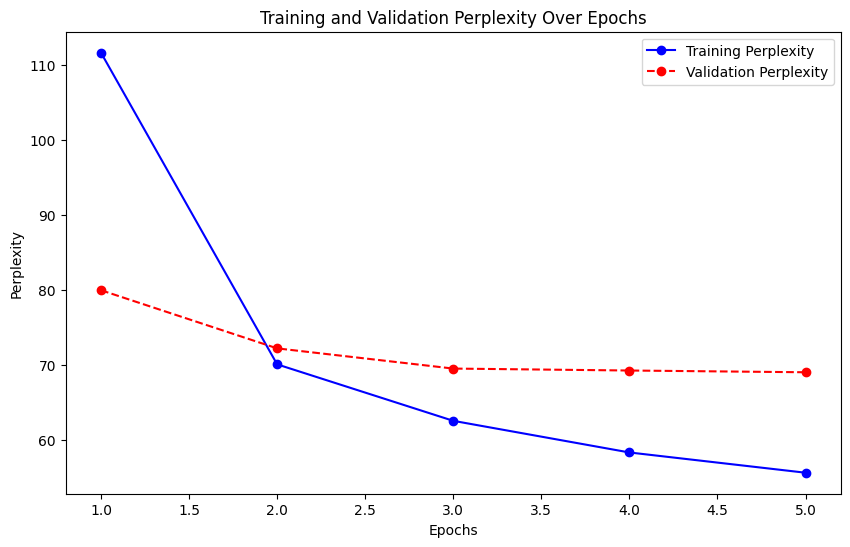

In [16]:
epochs = range(1, len(perp_vis_t) + 1)  # Assuming each entry corresponds to an epoch

plt.figure(figsize=(10, 6))
plt.plot(epochs, perp_vis_t, marker='o', linestyle='-', color='blue', label='Training Perplexity')
plt.plot(epochs, perp_vis_val, marker='o', linestyle='--', color='red', label='Validation Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Training and Validation Perplexity Over Epochs')
plt.legend()
plt.savefig('plot.png')
# plt.show()

In [17]:
# Save the entire model
torch.save(model, './model/model_LM3.pth')